In [2]:
class PID:
    """
    Control input: wheel rpm/angular velocity
    State: [pitch]
    """
    def __init__(self, Kp=0.0, Ki=0.0, Kd=0.0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd

        self.previous_error = 0.0
        self.integral = 0.0

    def update(self, error, dt) -> float:
        proportional = error
        self.integral = (error + self.previous_error) / 2 * dt
        derivative = (error - self.previous_error) / dt
        return self.Kp * proportional + self.Ki * self.integral + self.Kd * derivative

In [9]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
import math as m
from math import cos, sin, pi


class RaceCar():
    def __init__(self, params):
        self.params = params
        self.l = params['car_l']
        self.h = params['car_h']
        self.mass_car = params['car_mass']
        self.mass_wheel = params['wheel_mass']
        self.mass_axis = params['axis_mass']
        self.g = params['gravity']
        self.wheel_radius = params['wheel_radius']
        self.axis_radius = params['axis_radius']
        self.d = params['distance_cm']
        # Fixed for now; need a separate control problem if take take-off velocity as an input
        # self.take_off_v = params['take_off_velocity']
        # Duration for the entire motion
        self.duration = 3.0
        # Distance between two slopes
        self.distance = params['distance']
        self.angle0 = params['initial_angle']
        
        self.vel_min = 1.0
        self.vel_max = 5.0
        
        
        self.pid = PID(0.5, 1e-5, 1e-5) #PID pitch control
        self.dt = 0.001
        
    def calculate_angular_vel(self, v):
        """
        TODO: Need to confirm if we can calculate car's cuboid moment based on parallel-axis theorem. 
        https://physics.stackexchange.com/questions/734513/could-pressing-the-brakes-on-a-car-in-mid-air-affect-its-pitch-rotation
        Args:
          v:
            velocity of wheels in the air
        """
        I_w = 2* (self.mass_wheel * self.wheel_radius ** 2 + self.mass_axis * self.axis_radius**2)
        omega_w = v / self.wheel_radius
        L_w = omega_w * I_w
        I_cm = self.mass_car * (self.l**2+self.h**2) / 12
        I_parallel_axis = I_cm + self.mass_car * self.d**2
        omega_car = L_w / I_parallel_axis
        return omega_car
    
    def get_gt_position(self, t):
        """
        Get ground-truth position of car at timestamp t in inertial frame. 
        x aligns with car's x axis and y aligns with car's z axis.
        
        Args:
          t: 
            timestamp t
        """
        take_off_v = np.sqrt(self.distance * self.g/np.sin(2*self.angle0))
        x = ((take_off_v*t)*np.cos(self.angle0))
        y = ((take_off_v*t)*np.sin(self.angle0))-((0.5*self.g)*(t**2))
        return x, y
    
    def get_pitch_angle(self, t, v):
        """
        Get pitch angle at timestamp t.
        
        Args:
          t: 
            timestamp t
          v: 
            velocity of wheels in the air, from '/drive' topic
            
        """
        angular_vel = self.calculate_angular_vel(v)
        return angular_vel * t
    
    def step(self, t, v):
        gt_pitch = self.get_pitch_angle(t, v)
        noise = np.random.normal(0,1,1)
        curr_pitch = gt_pitch + noise #This is from IMU in reality
        error = np.abs(curr_pitch - gt_pitch)
        velocity_car = self.pid.update(error, self.dt)
        angular_velocity = velocity_car / self.wheel_radius
        return angular_velocity
        
    def get_state_response(self, v):
        """
        Generate state response of PID with control input v
        """
        distance_x = 0
        time = 0
        pitch_angles = []
        prev_angle = 0
        distances = []
        timestamps = []
        while distance_x < self.distance:
            distance_x, _ = self.get_gt_position(time)
            time += self.dt
            angular_velocity = self.step(time, v)
            pitch_angle = prev_angle + self.dt * angular_velocity
            prev_angle = pitch_angle
            pitch_angles.append(pitch_angle)
            distances.append(distance_x)
            timestamps.append(time)
        
        plt.plot(timestamps, pitch_angles)
        plt.title('pitch angles vs. t')
        plt.ylabel('Pitch angle')
        plt.xlabel('t')
        plt.show()
        
#         plt.plot(distances, pitch_angles)
#         plt.title('pitch angles vs. distance')
#         plt.ylabel('Pitch angle')
#         plt.xlabel('distances')
#         plt.show()

    def plot_pitch_angle(self, theta):
        fig = plt.figure()
        ax = fig.add_subplot(111)

        r1 = patches.Rectangle((0,0), self.l, self.h, color="blue", alpha=0.50)
        r2 = patches.Rectangle((0,0), self.l, self.h, color="red",  alpha=0.50)
        t2 = mpl.transforms.Affine2D().rotate_deg(theta*180) + ax.transData
        r2.set_transform(t2)
        ax.add_patch(r1)
        ax.add_patch(r2)
        plt.xlim(-20, 60)
        plt.ylim(-20, 60)
        plt.grid(True)
        plt.show()
        
    def animate_pitch(self, v):#TODO: debug
        fig = plt.figure()
        ax = fig.add_subplot(111)
        t = np.arange(0, self.duration, 0.1)  
        thetas = []
        def animate(theta):
            r1 = patches.Rectangle((0,0), self.l, self.h, color="blue", alpha=0.50)
            r2 = patches.Rectangle((0,0), self.l, self.h, color="red",  alpha=0.50)
            t2 = mpl.transforms.Affine2D().rotate_deg(theta*180) + ax.transData
            r2.set_transform(t2)
            ax.add_patch(r1)
            ax.add_patch(r2)
            return ax
            
        for dt in t:
            theta = self.get_pitch_angle(dt, v)
            thetas.append(theta)
        
        anim = animation.FuncAnimation(fig, animate, 
                               frames=thetas, 
                               interval=20,
                               blit=True)
        plt.show()
    

    def plot_projectile_motion(self, theta):
        # assume constant velocity
        v = 30
        
        t = np.linspace(0, 5, num=100) # Set time as 'continous' parameter.

        
        x1 = []
        y1 = []
        for k in t:
            x = ((v*k)*np.cos(theta)) # get positions at every point in time
            y = ((v*k)*np.sin(theta))-((0.5*self.g)*(k**2))
            x1.append(x)
            y1.append(y)
        p = [i for i, j in enumerate(y1) if j < 0] # Don't fall through the floor                          
        for i in sorted(p, reverse = True):
            del x1[i]
            del y1[i]

        plt.plot(x1, y1) # Plot for every angle
        plt.title('Parabola motion of car movement')
        plt.xlabel('x(t)')
        plt.ylabel('y(t)')
        plt.show() # And show on one graphic



In [13]:
# %matplotlib notebook
# These parameters may need to be adjusted
params = {'car_l': 0.3303*100, #centimeters #'lf': 0.15875, 'lr': 0.17145 according to f1tenth_gym
          'car_h': 0.145*100,  #centimeters
          'car_mass': 2.4192, #kg
          'wheel_mass': 0.1802,  #kg
          'axis_mass': 0.1, #kg #TODO
          'axis_radius': 0.01115*100, #centimeters
          'wheel_radius': 0.04826*100, #centimeters
          'distance_cm': 2.0, #centimeters: distance between the center of mass and the 
          'gravity': 9.81, #m/s^2
          'distance': 0.5, #m: distance between the ramps
          'initial_angle': np.pi/6 #radians, angle of the ramp
         }
v = 0.5 #m/s, control input
car = RaceCar(params)
car.get_state_response(0.5)
# pitch = car.get_pitch_angle(1.0, 5.0)
# car.step(1.0, 1.0)
# car.animate_pitch(2.0)
# car.plot_pitch_angle(pitch)
# car.plot_projectile_motion(np.pi/8)
# print(car.get_gt_position(1, 30, m.pi/6))

<IPython.core.display.Javascript object>

Enter initial velocity (m/s): 1.0
Enter angle (deg): 30


<IPython.core.display.Javascript object>


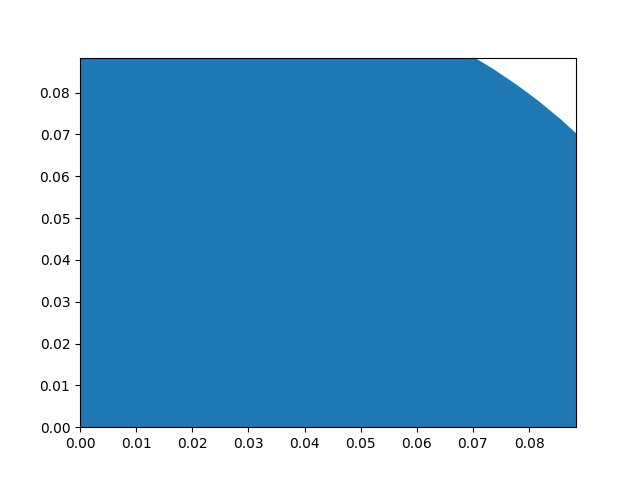

MovieWriter ffmpeg unavailable; using Pillow instead.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

g = 9.8

try:
    u = float(input('Enter initial velocity (m/s): '))
    theta = float(input('Enter angle (deg): '))
except ValueError:
    print('Invalid input.')
else:
    theta = np.deg2rad(theta)

t_flight = 2*u*np.sin(theta)/g
t = np.linspace(0, t_flight, 100)
x = u*np.cos(theta)*t
y = u*np.sin(theta)*t - 0.5*g*t**2

fig, ax = plt.subplots()
line, = ax.plot(x, y, color='k')

xmin = x[0]
ymin = y[0]
xmax = max(x)
ymax = max(y)
xysmall = min(xmax,ymax)
maxscale = max(xmax,ymax)
circle = plt.Circle((xmin, ymin), radius=np.sqrt(xysmall))
ax.add_patch(circle)

def update(num, x, y, line, circle):
    line.set_data(x[:num], y[:num])
    circle.center = x[num],y[num]
    line.axes.axis([0, max(np.append(x,y)), 0, max(np.append(x,y))])

    return line,circle

ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, y, line, circle],
                              interval=25, blit=True)

plt.show()